## The goal of this project: 
L1-regularized logistic regression: duality, sparsity,
and the geometry of optimization constraints. We train logistic
regression models with L1 regularization, we then
analyse how the regularization strength (λ) affects sparsity in the
weight vector and explore the dual interpretation of the L1 penalty.

It turns out that empirical risk minimization can lead to overfitting, i.e.,
the predictor fits too closely to the training data and does not generalize well to new data (Mitchell, 1997).

Therefore, we need to somehow bias the search for the minimizer of
empirical risk by introducing a penalty term, which makes it harder for
the optimizer to return an overly flexible predictor. In machine learning,
regularization the penalty term is referred to as regularization. Regularization is a way to compromise between accurate solution of empirical risk minimization
and the size or complexity of the solution.

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


### Loading the dataset

For the dataset I chose sklearn.datasets.load_breast_cancer  [(breast cancer Wisconsin dataset)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

I chose it because it’s simple but rich enough for exploring L1-regularized logistic regression. It’s a binary classification problem, which makes it perfect for logistic regression, and it has 30 features (computed from digitised images of fine neeedle aspirates of breast mass, it aims to classify tumors as malignant or benign), so we can actually see the effect of L1 regularization on sparsity. Also, since it’s a real medical dataset with some noise, it’s realistic but still easy to work with.

But what even is sparsity? Very quickly - sparsity means that most model coefficients are zero. In logistic regression, this results in a simpler model that uses only the most relevant features, improving interpretability and reducing overfitting.


In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

In [3]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
y.tail()

564    0
565    0
566    0
567    0
568    1
Name: target, dtype: int32

In [5]:
X.shape

(569, 30)

In [6]:
X.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [7]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


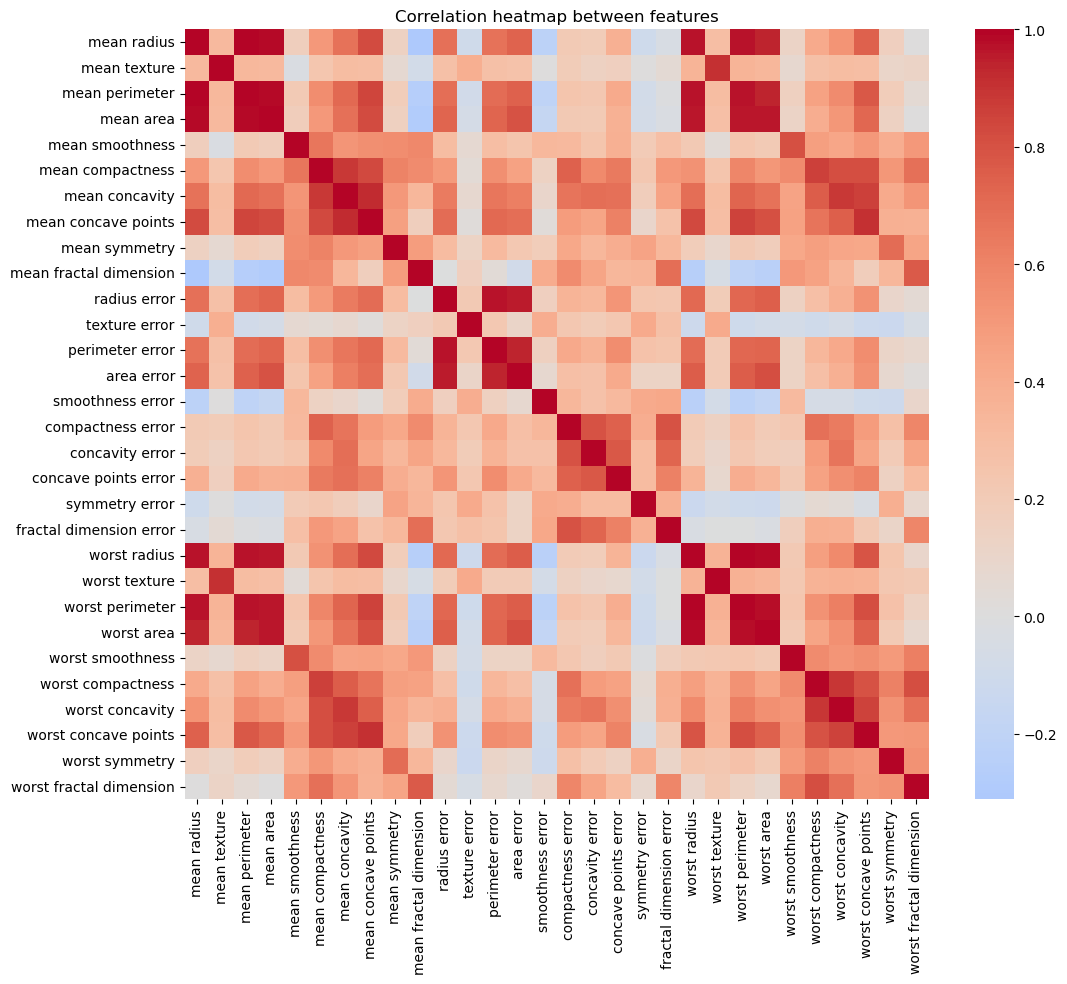

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap='coolwarm', center=0)
plt.title("Correlation heatmap between features")
plt.show()

Proportion of malignant (0) to benign (1): target
1    0.627417
0    0.372583
Name: proportion, dtype: float64

and their raw counts: target
1    357
0    212
Name: count, dtype: int64


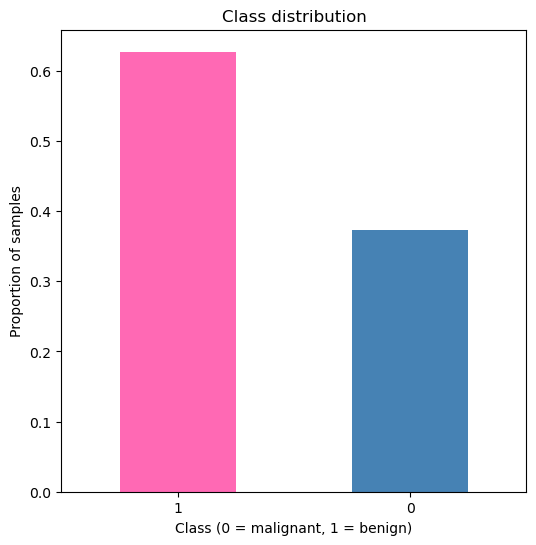

In [9]:
class_counts = y.value_counts(normalize=True) # return proportions rather than raw count
class_counts2 = y.value_counts() # return raw count
print(f"Proportion of malignant (0) to benign (1): {class_counts}\n\nand their raw counts: {class_counts2}")

plt.figure(figsize=(6,6))
class_counts.plot(kind='bar', color=['hotpink', 'steelblue'])
plt.title('Class distribution')
plt.xlabel('Class (0 = malignant, 1 = benign)')
plt.ylabel('Proportion of samples')
plt.xticks(rotation=0)
plt.show()

The dataset contains about 63% benign and 37% malignant cases. While this is a slight imbalance, it's not bad enough to require SMOTE or another oversampling method.

Instead, we can handle it easily by using:

```python
class_weight='balanced'
```
in our model, which will adjust the importance of each class during training without altering the data.

### Standardization

Since we'll be using L1-regularized logistic regression, it's important that all features are on the same scale. Otherwise, variables with larger ranges can unfairly dominate the results.

To address this, we apply standardization, which transforms each feature to have mean $\mu = 0$ and standard deviation $\sigma = 1$:

$$
z = \frac{x - \mu}{\sigma}
$$


Why Centering Matters?

Centering the data (setting mean to zero) is a crucial part of standardization and plays a key role in regularized linear models like Lasso, where it allows us to remove the intercept (bias term) from the optimization. This simplifies the math and ensures that regularization focuses on the actual feature weights, not on shifting the baseline.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### L1-Regularized Logistic Regression

Logistic regression is a widely used algorithm for binary classification. It models the relationship between input features and the probability of an outcome using the logistic (sigmoid) function, which maps values to a range between 0 and 1.

In this case, we apply L1-regularized logistic regression, which adds the L1 penalty to the loss function based on the absolute values of the weights. This encourages sparsity in the model, meaning many of the coefficients become exactly zero. This makes the model simpler and easier to interpret.


We use LogisticRegression from sklearn with the following settings:
*   penalty = 'l1' applies L1 regularization, which  can set model coefficients to zero, effectively performing feature selection
*   solver = 'liblinear' is required for the L1 penalty and handles binary classification by default
*   class_weight = 'balanced' adjusts for class imbalance

By training the model across different values of the regularization parameter lambda (represented as $C = 1 / λ $ in sklearn), we can observe how increasing regularization strength increases sparsity (percentage of zero coefficients) in the model.

### Training the model - gridsearch

In [12]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced'
)

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross validation accuracy:", grid.best_score_)


Best parameters: {'C': 1, 'max_iter': 100}
Best cross validation accuracy: 0.9714285714285715


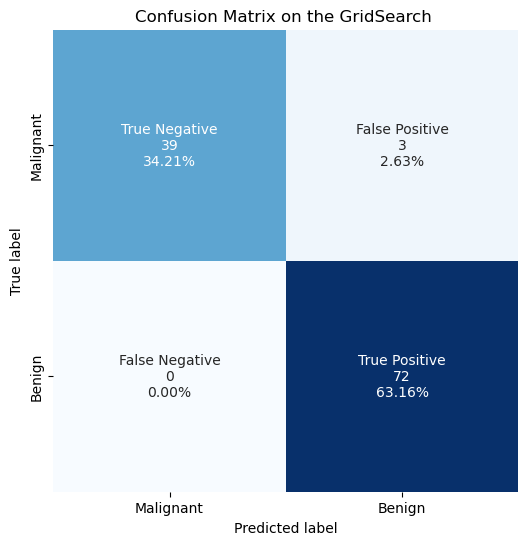

In [13]:
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test_scaled)

grid_confusion_matrix = confusion_matrix(y_test, y_test_pred)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = [f"{value:0.0f}" for value in grid_confusion_matrix.flatten()]
group_percentages = [f"{value:.2%}" for value in grid_confusion_matrix.flatten() / np.sum(grid_confusion_matrix)]
labels = [f"{name}\n{count}\n{percent}" for name, count, percent in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(6, 6))
sns.heatmap(grid_confusion_matrix, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix on the GridSearch ')
plt.show()

In [14]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (the best model from gridsearch): {accuracy:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_test_pred, target_names=['Malignant', 'Benign']))

Accuracy (the best model from gridsearch): 0.9737

Classification report:
              precision    recall  f1-score   support

   Malignant       1.00      0.93      0.96        42
      Benign       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



### Sparsity analysis

In sklearn, $C = \frac{1}{λ}$, where λ is the strength of regularization (how much of the penalty we put on larger weights).

So low C (e.g., 0.01) means high λ. Strong regularization = more sparsity. Of course it follows that high C or low λ (e.g., 100). Weak regularization = more non-zero coefficients. I want to show how the number of non-zero coefficients decreases as regularization strength increases.

In [15]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100] # log scale, includes C=1, which was our best one
# (C=0.001 regularization is very strong, 0.01-1 is moderate and 100 is weak)
non_zero_counts = []
accuracies = []

for C in C_values:
    model = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=100,  # we use 100 because that was our best value
        C=C
    )
    model.fit(X_train_scaled, y_train)
    
    # counting non zero weights
    non_zero = np.count_nonzero(model.coef_)
    non_zero_counts.append(non_zero)
    
    # tracking test accuracy
    acc = accuracy_score(y_test, model.predict(X_test_scaled))
    accuracies.append(acc)


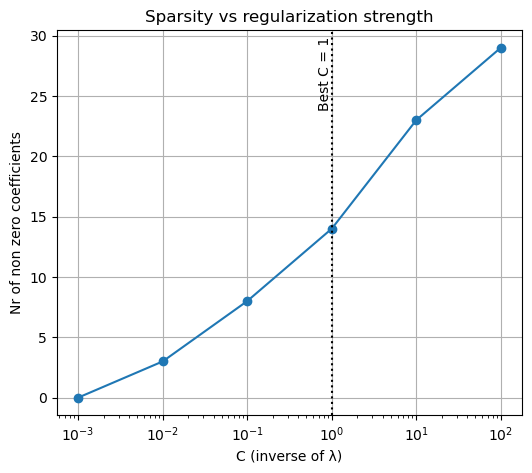

In [16]:
best_C = 1
plt.figure(figsize=(6,5))
plt.plot(C_values, non_zero_counts, marker='o')
plt.axvline(x=best_C, color='black', linestyle=':', label='Best C = 1')
plt.text(best_C, max(non_zero_counts) - 5, 'Best C = 1', rotation=90, color='black', ha='right')
plt.xscale('log')
plt.xlabel('C (inverse of λ)')
plt.ylabel('Nr of non zero coefficients')
plt.title('Sparsity vs regularization strength')
plt.grid(True)
plt.show()


We can see how the number of non-zero coefficients in the logistic regression model changes with the regularization strength (inversely of C). As C increases (weaker regularization), less coefficients are driven to zero.

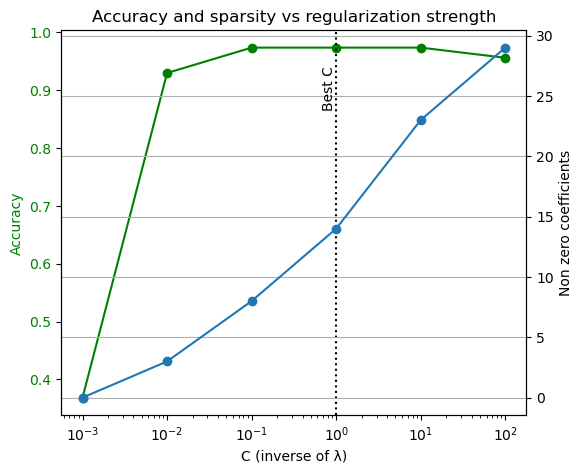

In [17]:
fig, ax1 = plt.subplots(figsize=(6,5))
ax1.set_xlabel('C (inverse of λ)')
ax1.set_ylabel('Accuracy', color="g")
ax1.plot(C_values, accuracies, marker='o', color="g")
ax1.tick_params(axis='y', labelcolor="g")
ax1.set_xscale('log')
ax1.axvline(x=1, color='black', linestyle=':', label='Best C = 1')

ax2 = ax1.twinx()
ax2.set_ylabel('Non zero coefficients')
ax2.plot(C_values, non_zero_counts, marker='o')
ax2.tick_params(axis='y')
ax2.text(1, max(non_zero_counts) - 5, 'Best C', rotation=90, color='black', ha='right')
plt.title('Accuracy and sparsity vs regularization strength')
plt.grid(True)
plt.show()


Here we compare accuracy for different values of C. We see that as regularization becomes weaker (C increases), accuracy improves until it stabilizes around C=1 (which was the best in our Grid Search), while the number of non-zero coefficients continues to rise, so we see the trade-off between model simplicity and performance, with C=1 being an optimal balance.

<Axes: title={'center': 'Feature importance (|weights|)'}>

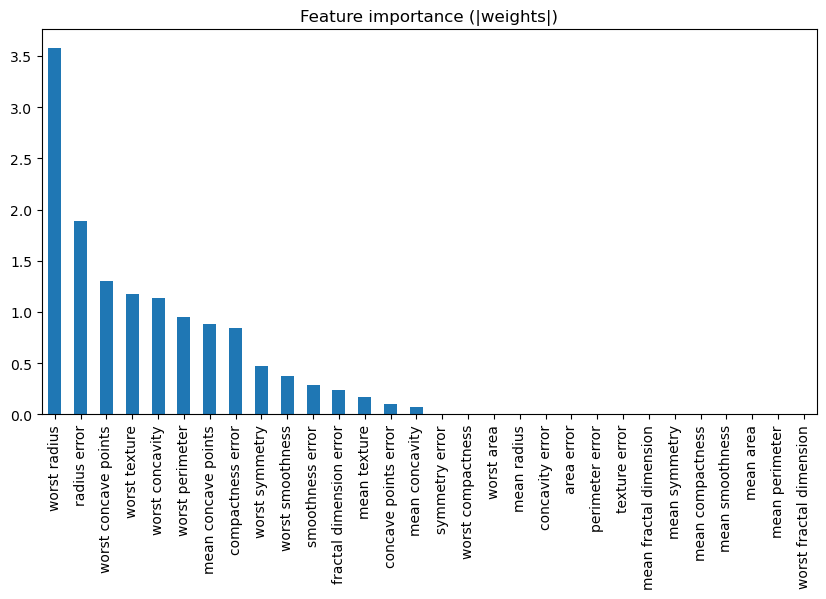

In [18]:
coef = pd.Series(np.abs(best_model.coef_.flatten()), index=X.columns)
coef.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title='Feature importance (|weights|)')


### Dual interpretation of the L1 penalty

In convex optimization, every constrained problem has a corresponding dual problem that offers a different (but equivalent) perspective on the solution.

For L1-regularized logistic regression, the primal problem is:

$
\min_{\mathbf{w}} \left[ \frac{1}{N} \sum_{i=1}^N \log\left(1 + e^{-y_i \mathbf{w}^\top \mathbf{x}_i} \right) + \lambda \|\mathbf{w}\|_1 \right]
$


The L1 penalty introduces a constraint on the solution space that geometrically corresponds to a diamond-shaped (L1 ball) feasible region in the coefficient (weight) space.

$
\sum_{i=1}^{n} |w_i| \leq \frac{1}{\lambda}
$


But why do we solve L1 regularised logistic regression in the primal (and not dual) form? 

From the dual perspective it's not as simple because L1-regularised logistic regression does not have a simple conjugate and the L1 norm introduces non smoothness (the dual formulation is complex and non smooth because the L1 norm is not differentiable). The primal formulation is more stable for high-dimensional and sparse problems — especially when many features are irrelevant, which L1 regularization is trying to exploit.

The convex conjugate of the L1 norm is an indicator function of an L∞ ball, which bounds the dual variables. This dual view explains why L1 induces sparsity: solutions often lie on the corners of the L1 ball, where one or more weights are exactly zero.

### Visualizing Why L1 Encourages Sparsity

To build geometric intuition, we can visualize how the L1 constraint shapes the solution space for a 2D coefficient vector $[w_1, w_2]$.

In this 3D plot:

- The colored surface is the loss function.
- The black diamond shape on the base plane represents the L1 constraint region (an L1 ball).
- The red dot shows the minimum of the loss subject to the constraint.
- The solution lies on the edge or corner of the L1 ball, meaning one of the coefficients becomes zero.

This corner-seeking behavior explains why L1 regularization induces sparsity — unlike L2 regularization, which uses a circular constraint and rarely results in exact zeros.

---

### Note on the 3D Visualization of L1 Regularization

I initially tried to visualize the sparsity-inducing effect of L1 regularization using my own dataset by reducing it to two features based on correlations between target and features. However, the results were not very interpretable or visually representative of the geometric intuition found in textbooks.

To properly illustrate the intuition behind L1 regularization (why it induces sparsity), I adapted a clean 3D visualization from [Aidar Maitbayev’s blog post](https://maitbayev.github.io/posts/why-l1-loss-encourage-coefficients-to-shrink-to-zero/). This part of the code is not original, but I chose to include it because it clearly communicates a concept that was difficult to demonstrate for me with my real world data.


In [19]:
from enum import Enum

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Polygon


def loss(b0, b1, cx, cy, scale=2.0, bias=100):
    return scale * (b0 - cx) ** 2 + scale * (b1 - cy) ** 2 + bias


class Reg(Enum):
    L1 = 1
    L2 = 2


def make_reg_shape(reg: Reg, t: float, color="k"):
    if reg == Reg.L1:
        return Polygon(xy=[(t, 0), (0, t), (-t, 0), (0, -t)], color=color, fill=False, linestyle='--')
    else:
        return Circle(xy=(0, 0), radius=t, color=color, fill=False, linestyle='--')


def argmin_within_constraint(reg: Reg, t: float):
    beta0 = np.linspace(*beta_range, 100)
    beta1 = np.linspace(*beta_range, 100)
    B0, B1 = np.meshgrid(beta0, beta1)
    Z = loss(B0, B1, cx=cx, cy=cy)
    if reg == Reg.L1:
        mask = np.abs(B0) + np.abs(B1) <= t
    else:
        mask = B0 * B0 + B1 * B1 <= t * t
    index = np.argmin(Z[mask])
    return B0[mask][index], B1[mask][index]


beta_range = -20, 20
cx, cy = 15, 5
vmax = 1000

In [20]:
def base_fig3():
    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("$\\beta_1$", labelpad=0)
    ax.set_ylabel("$\\beta_2$", labelpad=0)
    ax.set_zlim(0, 500)
    ax.tick_params(axis='x', pad=0)
    ax.tick_params(axis='y', pad=0)
    ax.set_xlim(*beta_range)
    ax.set_ylim(*beta_range)
    # draw axes
    ax.plot(beta_range, [0, 0], color='k')
    ax.plot([0, 0], beta_range, color='k')
    return fig, ax


def plot3d(reg: Reg, t=3):
    fig, ax = base_fig3()

    # surface
    beta0 = np.linspace(*beta_range, 100)
    beta1 = np.linspace(*beta_range, 100)
    B0, B1 = np.meshgrid(beta0, beta1)
    Z = loss(B0, B1, cx=cx, cy=cy)
    ax.plot_surface(B0, B1, Z, alpha=0.7, cmap='coolwarm', vmax=vmax)

    # contours
    ax.plot([cx], [cy], marker='x', markersize=10, color='black')
    ax.contour(B0, B1, Z, levels=50, linewidths=.5, cmap='coolwarm', zdir='z', offset=0, vmax=vmax)
    
    # minima within regularization shape
    mx, my = argmin_within_constraint(reg, t)
    ax.plot([mx], [my], marker='.', markersize=10, color='r')

    # regularization contraints
    reg_shape = make_reg_shape(reg, t, color="black")
    ax.add_patch(reg_shape)
    art3d.pathpatch_2d_to_3d(reg_shape, z=0)

    ax.view_init(elev=39, azim=-106)
    plt.tight_layout()
    plt.show()

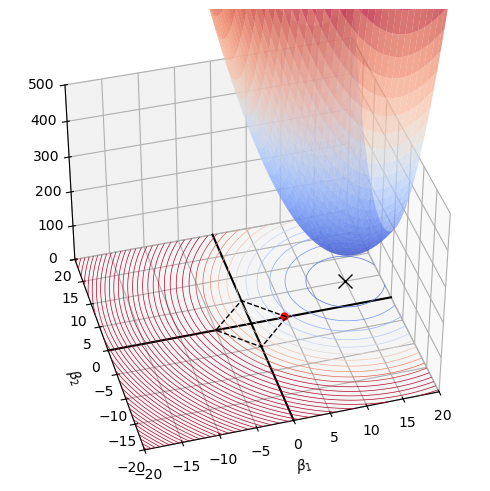

In [21]:
plot3d(Reg.L1, t=5)

### In conclusion

L1 regularization encourages sparsity by penalizing the absolute values of the model coefficients, effectively driving many of them to zero. As the regularization strength increases (lower C), the model becomes simpler, often without a significant loss in accuracy. This leads to better interpretability and reduced overfitting, especially in high-dimensional settings.

Geometrically, the L1 constraint creates a solution space with corners, making it more likely for the optimizer to land on sparse solutions.

Overall, in my opinion, L1-regularized logistic regression offers a great balance between predictive performance and model simplicity.